# 0. Basics

## 0.0. Imports

In [157]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [2]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G
from WS_Mdl.utils import bold, style_reset

In [3]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\geo.py'>

In [4]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import MultiLineString, box

In [5]:
from imod import msw
from imod import mf6
import primod

In [6]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [7]:
import DRN_SFR_match
from DRN_SFR_match import match_cells_to_SFR
import w_MVR
from w_MVR import w_MVR

## 0.1. Options

In [8]:
Pa_GPkg_1ry = r'C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\WBD_SW_NW_1ry.gpkg' 
Pa_GPkg = r"C:\OD\WS_Mdl\models\NBr\PrP\SFR\BrabantseDelta\acceptatiedatabase.gdb"
detailed = 'hydroobject'
primary = 'LEGGER_VASTGESTELD_WATERLOOP_CATEGORIE_A'

In [9]:
MdlN = 'NBr36'

In [10]:
U.set_verbose(False)

In [180]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

In [12]:
U.Mdl_Dmns_from_INI(d_Pa['INI'])

(113100.0, 387600.0, 125100.0, 396200.0, 25.0, 344, 480)

# 1. Load Model Ins

## 1.0. Load PRJ

In [13]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [14]:
PRJ, period_data = PRJ_[0], PRJ_[1]

## 1.1. Load DIS and limit to Mdl Aa

In [15]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [16]:
BND = PRJ_regrid['bnd']['ibound']

In [17]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


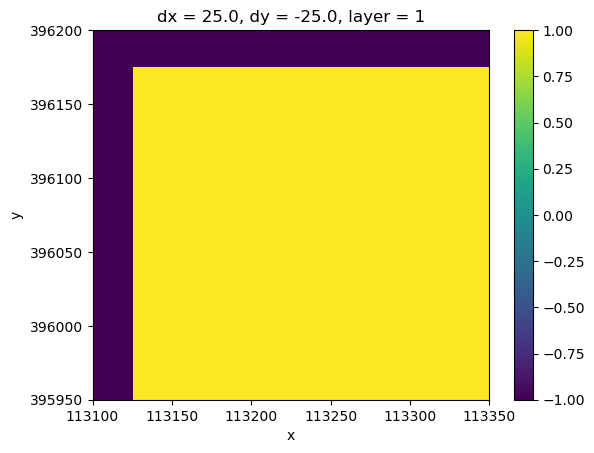

In [18]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

## 1.2. Load MF6 Mdl

In [19]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [20]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

In [21]:
MF6_Mdl = Sim_MF6['imported_model']

In [22]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

In [23]:
MF6_DIS = MF6_Mdl["dis"]  # This gets the OLD 100m grid

## 1.3. Load MSW

### 1.3.0. Fix mete_grid.inp relative paths

In [24]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ_regrid)

Created corrected mete_grid.inp: C:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\models\NBr\In\CAP\mete_grid\NBr1\temp\mete_grid.inp


### 1.3.2. Finally load MSW Sim

In [25]:
# Create the MetaSwap model
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🟢 - MetaSwap model loaded successfully!")

🟢 - MetaSwap model loaded successfully!


## 1.4. Connect MF6 to MetaSWAP

### 1.4.1. Clip models

In [26]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [27]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [28]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


## 1.5. Load & Cleanup models

### 1.5.0. Load

In [29]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

### 1.5.1. MF6 mask

In [30]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [31]:
# Fix CHD package layer ordering issue (layers must be monotonically increasing)
from imod.mf6 import ConstantHead
chd_pkg = Sim_MF6_AoI['imported_model']['chd_merged']
head_data_sorted = chd_pkg.dataset['head'].load().sortby('layer')
Sim_MF6_AoI['imported_model']['chd_merged'] = ConstantHead(head=head_data_sorted, validate=False)

In [32]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### 1.5.2. Cleanup MF6

In [33]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packages. Proceeding without cleanup. Fingers crossed!')

### 1.5.3 Cleanup MetaSWAP

In [34]:
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## 1.6. Couple & Write

In [35]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [36]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [37]:
# Use correct paths from d_Pa instead of hardcoded paths
Pa_MF6_DLL = d_Pa['MF6_DLL']
Pa_MSW_DLL = d_Pa['MSW_DLL']
Pa_IMC = d_Pa['coupler_Exe']

print(f"✅ MF6 DLL path: {Pa_MF6_DLL}")
print(f"✅ MSW DLL path: {Pa_MSW_DLL}")
print(f"✅ Coupler exe path: {d_Pa['coupler_Exe']}")

✅ MF6 DLL path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4\./modflow6/libmf6.dll
✅ MSW DLL path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4\./metaswap/MetaSWAP.dll
✅ Coupler exe path: C:/OD/WS_Mdl\software/iMOD5/IMC_2024.4/imodc.exe


In [38]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

# 2. Create SFR lines

## 2.1.Load shapefile

In [39]:
GDF_all = gpd.read_file(Pa_GPkg_1ry)

## 2.2. Calculate routing

### 2.2.0 Extract coordinates and identify downstream segments.

#### Create X & Y columns

In [40]:
GDF_all['Xstart'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[0][0]) # Access X coorddinate of first point in first linestring
GDF_all['Ystart'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[0][1])
GDF_all['Xend'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[-1][0])
GDF_all['Yend'] = GDF_all['geometry'].apply(lambda x: x.geoms[0].coords[-1][1])

In [41]:
print("✓ Start and end coordinates extracted.")
l_coord_cols = ['CODE', 'Xstart', 'Ystart', 'Xend', 'Yend']
GDF_all[l_coord_cols].head()

✓ Start and end coordinates extracted.


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Limit X, Y to model area

In [42]:
GDF = GDF_all[  ( (GDF_all['Xstart'].between(Xmin, Xmax, inclusive='both') | GDF_all['Xend'].between(Xmin, Xmax, inclusive='both') ) &
              (GDF_all['Ystart'].between(Ymin, Ymax, inclusive='both') | GDF_all['Yend'].between(Ymin, Ymax, inclusive='both') ) ) ]

In [43]:
# Create a lookup dictionary from start coordinates to CODE
coord_to_id = {(row.Xstart, row.Ystart): (row.CODE, row.OBJECTID) for row in GDF.itertuples()}

print(f"✓ Lookup dictionary created with {bold}{len(coord_to_id)}{style_reset} entries.")

✓ Lookup dictionary created with 583 entries.


#### Identify downstream

In [44]:
# Function to find the downstream ID
def get_DStr(row):
    end_coords = (row.Xend, row.Yend)
    result = coord_to_id.get(end_coords, (0, 0))
    return result

# Apply the function to create the 'DStr' column
GDF[['DStr_code', 'DStr_ID']] = GDF.apply(get_DStr, axis=1, result_type='expand')

print("✓ 'DStr' columns calculated.")

✓ 'DStr' columns calculated.


In [45]:
print(f'{round(GDF['DStr_code'].value_counts().max()/GDF.shape[0]*100, 2)} % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).')

9.48 % of DStrs are 0 (i.e. no start coordinates match the end coordinates of the current node).


The percentage is bigger than expected. Let's investigate.

### 2.2.1 Investigate segments that failed to connect

#### Check out number of matches/no matches

In [46]:
GDF['DStr_match'] = GDF['DStr_code'].isin(GDF['CODE'])
GDF['DStr_code'].value_counts()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


It makes sense that most nodes have just a few upstream nodes. 56 nodes are not connected.

In [47]:
GDF['DStr_match'].value_counts()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Calculate min distance from start to any reach's end and investigate no matches.

In [48]:
GDF['min_Dist'] = 0.0
GDF.loc[GDF['DStr_code'] == 0, 'min_Dist'] = GDF.loc[GDF['DStr_code'] == 0].apply(lambda row: C.c_Dist(row['Xend'], row['Yend'], GDF['Xstart'], GDF['Ystart']).min(), axis=1)

In [49]:
N_total_no_match = (GDF['DStr_code'] == 0).sum()

In [50]:
GDF.loc[GDF['DStr_match']==False,'min_Dist'].describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [51]:
l_Vals = [0.001, 0.1, 1, 10, 100, 1000, 10000]

print(f'Out of the {N_total_no_match} segments that do not match:')

N_below_Prv, Val_Prv = 0, 0
for v in l_Vals:
    N_below = (GDF.loc[GDF['DStr_match']==False,'min_Dist'] <= v).sum()
    P_below = round(N_below / N_total_no_match * 100, 2)
    
    sample_gdf = GDF.loc[(GDF['min_Dist'] > Val_Prv) & (GDF['min_Dist'] <= v), ['CODE', 'min_Dist']].sort_values(by='min_Dist')
    sample_gdf['Code:min_Dist'] = sample_gdf.apply(lambda row: f"{row['CODE']}: {row['min_Dist']:8.4f}", axis=1)
    sample_gdf = sample_gdf['Code:min_Dist']
    example_nodes = sample_gdf.iloc[:].tolist()

    print(f'-{Val_Prv:6} < min_Dist <= {v:5} |N: {N_below:6} (+ {(N_below - N_below_Prv):4}) ({round(P_below,1):5} %) | Codes: {example_nodes}\n')

    N_below_Prv, Val_Prv = N_below, v

Out of the 56 segments that do not match:
-     0 < min_Dist <= 0.001 |N:     37 (+   37) ( 66.1 %) | Codes: ['OVK02919:   0.0001', 'OVK02936:   0.0001', 'OVK02055:   0.0001', 'OVK02089:   0.0001', 'OVK01666:   0.0001', 'OVK20480:   0.0001', 'OVK20466:   0.0001', 'OVK02235:   0.0001', 'OVK00961:   0.0001', 'OVK20990:   0.0001', 'OVK01440:   0.0001', 'OVK00937:   0.0001', 'OVK01445:   0.0001', 'OVK00976:   0.0001', 'OVK01793:   0.0001', 'OVK01694:   0.0001', 'OVK02909:   0.0001', 'OVK00907:   0.0001', 'OVK01716:   0.0001', 'OVK01492:   0.0001', 'OVK02214:   0.0001', 'OVK00960:   0.0001', 'OVK00965:   0.0001', 'OVK01537:   0.0001', 'OVK02101:   0.0001', 'OVK01675:   0.0001', 'OVK02326:   0.0001', 'OVK01803:   0.0002', 'OVK20449:   0.0003', 'OVK02098:   0.0003', 'OVK22007:   0.0003', 'OVK01674:   0.0004', 'OVK00975:   0.0005', 'OVK01717:   0.0006', 'OVK11693:   0.0006', 'OVK00974:   0.0006', 'OVK11686:   0.0010']

- 0.001 < min_Dist <=   0.1 |N:     41 (+    4) ( 73.2 %) | Codes: ['OVK021

The total number of segments that do not match is too high to check them all, but we'll check some cases. Check C:\OD\WS_Mdl\Mng\Mdl_Ipvs.xlsx/WBD_SHP_Eval for more info.

The ones <1m can be attributed to closing errors, and we can connect them to the closest one via an algorithm.<br>Let's print out the names of the bigger differences, so that we can check them in QGIS.

In [52]:
GDF.loc[GDF['min_Dist'].between(10,100, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- **OVK11551**: -- TO BE CORRECTED -- is an anomaly, as it attaches to a very long feature, far from the final start and end.
- **OVK02333**: -- IGNORE -- ends outside the model, so there is no feature to connect to.
- **OVK02830** & **OVK02160**: -- IGNORE -- are in the same spot. one of them is straight, the other one circles around, and they both end outside the model.
- **OVK01792**: -- IGNORE -- also ends outside the model.

In [53]:
GDF.loc[GDF['min_Dist'].between(100,1000, inclusive='right'), ['CODE', 'min_Dist']].sort_values(by='min_Dist').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


- **OVK02242**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02238**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02121**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01807**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK03078**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK02887**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek (final Mark outled outside MdlAa) 
- **OVK02933**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK01682**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 
- **OVK00416**: --- IGNORE --- ends outside the model and doesn't have any impact on Chaamse Beek 


### 2.2.2 Edit connections

In [54]:
# Initialize the 'multiple_close' column with empty strings
GDF['multiple_close'] = ""

# Select rows to correct
rows_to_correct = GDF[(GDF['DStr_code'] == 0) & (GDF['min_Dist'] < 1)].copy()

print(f"Found {len(rows_to_correct)} segments with no downstream connection and a potential connection within 1m.")

# Create a Series of all start coordinates for faster access
all_starts_x = GDF['Xstart']
all_starts_y = GDF['Ystart']
all_codes = GDF['CODE']
all_object_ids = GDF['OBJECTID']

corrected_count = 0
multiple_count = 0

# Loop through the rows that need correction
for index, row in rows_to_correct.iterrows():
    # Calculate distances from the current row's end point to all other rows' start points
    distances = C.c_Dist(row['Xend'], row['Yend'], all_starts_x, all_starts_y)
    
    # Find segments where the distance is less than 1m
    close_mask = (distances < 1) & (GDF.index != index) # Exclude self
    close_segments_codes = all_codes[close_mask].tolist()
    close_segments_object_ids = all_object_ids[close_mask].tolist()
    
    if len(close_segments_codes) == 1:
        # If there is exactly one close segment, update both 'DStr_code' and 'DStr_ID'
        GDF.loc[index, 'DStr_code'] = close_segments_codes[0]
        GDF.loc[index, 'DStr_ID'] = close_segments_object_ids[0]
        corrected_count += 1
    elif len(close_segments_codes) > 1:
        # If there are multiple close segments, store as comma-separated string
        GDF.loc[index, 'multiple_close'] = ", ".join(close_segments_codes)
        multiple_count += 1

print(f"✓ Corrected {corrected_count} segments by updating 'DStr_code' and 'DStr_ID'.")
print(f"✓ Found {multiple_count} segments with multiple potential connections (stored in 'multiple_close').")

Found 42 segments with no downstream connection and a potential connection within 1m.
✓ Corrected 41 segments by updating 'DStr_code' and 'DStr_ID'.
✓ Found 1 segments with multiple potential connections (stored in 'multiple_close').


In [55]:
GDF.loc[GDF['multiple_close']!='', ['CODE', 'multiple_close']].sort_values(by='multiple_close', ascending=False)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


This is an upstremost segment that's really small, so it doesn't matter much where it connects to. We'll connect it to one of the two downstream segments at random.

In [56]:
GDF.loc[GDF['CODE']=='OVK00976', ['DStr_code', 'DStr_ID']] = ['OVK00977', GDF.loc[GDF['CODE']=='OVK00977', 'OBJECTID'].values[0]]

Let's also fix OVK11551, which connects to that very long segment (OVK03013), far from either end.

In [57]:
GDF.loc[GDF['CODE']=='OVK11551', ['DStr_code', 'DStr_ID']] = ['OVK03013', GDF.loc[GDF['CODE']=='OVK03013', 'OBJECTID'].values[0]]

## 2.3. Explore GDF to fill SFRmaker input requirements

### 2.3.0 Custom Hydrography Required Fields

Below, we'll match the shapefile attributes to the SFRmaker requirements as per SFRmaker manual ( https://doi-usgs.github.io/sfrmaker/latest/inputs.html):

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. **flowlines_file**: path to shapefile
2. **id_column**: unique identifier for each polyline
3. **routing_column**: downstream connection (ID), 0 if none
4. **width1_column**: channel width at start of line, in attr\_length\_units (optional)
5. **width2_column**: channel width at end of line, in attr_length_units (optional)
6. **up_elevation_column**: streambed elevation at start of line, in attr_height_units
7. **dn_elevation_column**: streambed elevation at end of line, in attr_height_units
8. **name_column**: stream name (optional)
9. **attr_length_units**: channel width units
10. **attr_height_units**: streambed elevation units

Here are the columns of the GDF, so we can match them to the SFRmaker requirements:

In [58]:
for i, col in enumerate(GDF.columns):
    print(f"{i}: {col}")

0: OBJECTID
1: CODE
2: WS_STATUS_L
3: WS_LEGGERCATEGORIE_L
4: WS_LEGGERBRON_L
5: DATUM_VASTGESTELD
6: LEGGER_KENMERK
7: WS_ONDERHOUDSPLICHTIGE_L
8: WS_ONDERHOUDSPLICHT_L
9: WS_BODEMBREEDTE_L
10: WS_BH_BOVENSTROOMS_L
11: WS_BH_BENEDENSTROOMS_L
12: WS_BODBREE_ACCPROF_LI_L
13: WS_BODBREE_ACCPROF_RE_L
14: WS_HGT_INSTEEK_LI_L
15: WS_HGT_INSTEEK_RE_L
16: WS_BHGT_ACCPROF_LI_L
17: WS_BHGT_ACCPROF_RE_L
18: WS_TALUD_LINKS_L
19: WS_TALUD_RECHTS_L
20: WS_TALUD_ACCPROF_LI_L
21: WS_TALUD_ACCPROF_RE_L
22: WS_ONDERWATERTALUD_LI_L
23: WS_ONDERWATERTALUD_RE_L
24: WS_HGT_BESCHOEIING_LI_L
25: WS_HGT_BESCHOEIING_RE_L
26: WS_HGT_ONDERK_BES_LI_L
27: WS_HGT_ONDERK_BES_RE_L
28: WS_HGT_INSTEEK_ACCPROF_LI_L
29: WS_HGT_INSTEEK_ACCPROF_RE_L
30: WS_BIJZ_FUNCTIE_L
31: WS_INHOUD_RETENTIE_L
32: WS_LENGTE_L
33: WS_OPW_BIJZ_PROF_L
34: WS_VW_BODEMBREEDTE_L
35: WS_VW_BH_BOVENSTROOMS_L
36: WS_VW_BH_BENEDENSTROOMS_L
37: WS_VW_TALUD_LINKS_L
38: WS_VW_TALUD_RECHTS_L
39: WS_VW_BIJZ_PROF_L
40: WIJZIGING
41: SE_ANNO_CAD_DATA
42:

### 2.3.2 Explore GDF fields

#### 2. & 3. will most likely be 'OBJECTID' & 'DStr_ID'.

But let's ensure there are no nulls and use the .describe() method to check more details

In [59]:
GDF[['OBJECTID', 'DStr_ID']].isna().sum()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [60]:
GDF[['CODE', 'OBJECTID', 'DStr_code', 'DStr_ID']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [61]:
GDF.loc[GDF['DStr_ID']==0, 'DStr_ID'].count()

np.int64(13)

Great. No nuls and 13 DStr_codes with no downstream connection ('DStr'==0) (9 with min_Dist between 100 and 1000, + 5 with min_Dist betwen 10 and 100, -1, that we connected to the meandering long segment).

#### 4. & 5. Widths (at start and end)

There are 4 candidates for those fields:
- 'WS_BODEMBREEDTE_L' (channel bed width)
- 'WS_BODBREE_ACCPROF_LI_L' (Accepted profile bottom width (left) (m))
- 'WS_BODBREE_ACCPROF_RE_L' (Accepted profile bottom width (right) (m))
- 'WS_VW_BODEMBREEDTE_L' (Prescribed bottom width (voorwaarde) (m))

Let's compare the values. We can probably just use WS_BODEMBREEDTE. I think it has no/fewer nuls and the values are similar to the other 3 fields. Then we can upgrade. But let's have a look.

In [62]:
GDF[['CODE', 'OBJECTID', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [63]:
GDF.loc[ GDF['WS_BODBREE_ACCPROF_LI_L'].notna() | GDF['WS_BODBREE_ACCPROF_RE_L'].notna() | GDF['WS_VW_BODEMBREEDTE_L'].notna(),
         ['CODE', 'WS_BODEMBREEDTE_L', 'WS_BODBREE_ACCPROF_LI_L', 'WS_BODBREE_ACCPROF_RE_L', 'WS_VW_BODEMBREEDTE_L']]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


'WS_BODBREE_ACCPROF_LI_L' & 'WS_BODBREE_ACCPROF_RE_L' are not the bottom of the channel. This is clear if we masure the channel width in QGIS. So we won't use those.<br>
'WS_VW_BODEMBREEDTE_L' only has nulls, so we won't use that either.<br>
**So we'll just use 'WS_BODEMBREEDTE_L'.**

#### 6. & 7. Upstream and downstream elevations

In [64]:
GDF[[ 'CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']].describe(include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


No nulls + the percentiles make sense.🟢<br>
Let's make sure the UStr is always higher than the DnStr.<br>
Then let's print out some values to check in QGIS.

In [65]:
(GDF['WS_BH_BOVENSTROOMS_L'] <= GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] < GDF['WS_BH_BENEDENSTROOMS_L']).sum(), (GDF['WS_BH_BOVENSTROOMS_L'] > GDF['WS_BH_BENEDENSTROOMS_L']).sum(), GDF.shape[0]

(np.int64(98), np.int64(24), np.int64(493), 591)

For 98 segments (out of 591), the UStr Elv is <= the DStr Elv. This is not good. We'll have to fix this. 🔴<br>
Only 24/99 have DStr < UStr , the rest are equal. = will be corrected by SFR itself (as far as I know), so no action is required for those.

##### Let's print out some CODEs where =, to check in QGIS. *(We don't really need to, I'm just curious)*

In [66]:
GDF_Elv = GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L', 'DStr_code', 'DStr_ID']].copy()

In [67]:
GDF_Elv['Diff'] = GDF_Elv['WS_BH_BOVENSTROOMS_L'] - GDF_Elv['WS_BH_BENEDENSTROOMS_L']

In [68]:
GDF_Elv.loc[GDF_Elv['Diff'] == 0].head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [69]:
GDF_Elv.loc[ GDF_Elv['Diff'] < 0 ].sort_values(by='Diff', ascending=True).head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Let's see if any of the problematic segments have multiple UStr segments. That would make a solution harder to implement.<br>
*(if there is only 1 UStr segment, the DStr Elv of the UStr segment can be modified to allow the UStr Elv of the current segmet to be increased as well, but if there are multiple, this becomes more complicated)*

In [70]:
l_problematic = GDF_Elv.loc[ GDF_Elv['Diff'] < 0, 'CODE'].tolist()
for S in l_problematic:
    sum = (GDF['DStr_code']==S).sum()
    if sum > 1:
        print(S, sum)

OVK02982 2
OVK21050 2
OVK03070 3
OVK02326 2
OVK01434 2


There are multiple segments with more than 1 UStr segment. We'll have to consider this when designing the elevation correction logic. 

##### Elv correction algorithm

We'll design an algorithm to fix those with <. Those with = will be fixed by SFR itself (hopefully). The following abbreviations are useful for explaining the concept:
- A: DStr Elv of DStr segment
- B: UStr Elv of DStr segment
- C: DStr Elv of current segment
- D: UStr Elv of current segment
- F: DStr Elv of UStr segment(s)

Here is the idea behind the algorithm:
1. If **C > D & B <= D** :<br>
-> Set **C = D**
2. If **C > D & B > D** :<br>
-> Set **C = D**. Set **B = D**
3. If **C <= D** :<br>
-> **No action**.

Repeat till there are no segments with C < D.

When there is no downstream segment, we apply the logic used in case 1.

In [71]:
GDF_Elv = GDF_Elv.merge(GDF[['CODE', 'WS_BH_BOVENSTROOMS_L', 'WS_BH_BENEDENSTROOMS_L']], left_on='DStr_code', right_on='CODE', suffixes=('', '_DStr'), how='left')

In [72]:
GDF_Elv[['A', 'B']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L_DStr', 'WS_BH_BOVENSTROOMS_L_DStr']].copy()

In [73]:
GDF_Elv[['C', 'D']] = GDF_Elv[['WS_BH_BENEDENSTROOMS_L', 'WS_BH_BOVENSTROOMS_L']].copy()

In [74]:
GDF_Elv[GDF_Elv['B'].isna()]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [75]:
init = GDF_Elv.loc[ GDF_Elv['CODE']=='OVK02121', 'B' ].values[0]

In [76]:
def adjust_elevations(row):
    if row['C'] <= row['D']: # If UStr Elv <= DStr Elv, no adjustment needed
        return row['B'], row['C']
    elif (row['C'] > row['D']) and (pd.isna(row['B'])): # If UStr Elv <= DStr Elv but DStr Elv is missing (OuFl segment), set both to DStr Elv
        return pd.NA, row['D']
    elif (row['C'] > row['D']) and (row['B'] <= row['D']):
        return row['B'], row['D']
    elif (row['C'] > row['D']) and (row['B'] > row['D']):
        return row['D'], row['D']
    else:
        # Default case - should not happen, but ensures function always returns a tuple
        return row['B'], row['C']

In [77]:
GDF_Elv[['B_', 'C_']] = GDF_Elv.apply(adjust_elevations, axis=1, result_type='expand')

I'm worried consequtive segments might be problematic. Let's check if there are any.

In [78]:
GDF_Elv_unfixed = GDF_Elv[ (GDF_Elv['Diff']<0)]
consequtive = GDF_Elv_unfixed.loc[GDF_Elv_unfixed['DStr_code'].isin(GDF_Elv_unfixed['CODE']), 'DStr_code']
GDF_Elv_unfixed.loc[ (GDF_Elv_unfixed['CODE'].isin(consequtive)) | (GDF_Elv_unfixed['DStr_code'].isin(consequtive)), ['CODE', 'DStr_code', 'A', 'B', 'B_', 'C', 'C_', 'D']].sort_values(by='D').reset_index(drop=True)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Consequtive ok. Let's check if there is a drop in Elv (positive slope) for each segment.

In [79]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['C_'] < 0 ]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Cool, no segments without any drop in Elv.

In [80]:
GDF_Elv['segment_drop'] = GDF_Elv['D'] - GDF_Elv['C_']
GDF_Elv['DStr_drop'] = GDF_Elv['C_'] - GDF_Elv['B']
GDF_Elv.loc[ GDF_Elv['C_'] - GDF_Elv['B_'] < 0 , ['CODE', 'DStr_code', 'A', 'B', 'B_', 'C', 'C_', 'D', 'segment_drop', 'DStr_drop'] ].sort_values(by='DStr_drop').reset_index(drop=True) 

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


There are **quite a few** segments where C_ > B!!! SFRmaker might fix this. If not, I'll come back and fix it.

#### Conclusion

**Custom hydrography** <br>
Any Polyline shapefile can be supplied in lieu of NHDPlus, but it must have the following columns, as shown in the second example:
1. flowlines_file: path to shapefile <br>
    -> **Pa_GPkg_1ry** <br>
2. id_column: unique identifier for each polyline <br>
    -> **OBJECTID** <br>
3. routing_column: downstream connection (ID), 0 if none <br>
    -> **DStr_ID** <br>
4. width1_column: channel width at start of line, in attr\_length\_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
5. width2_column: channel width at end of line, in attr_length_units (optional) <br>
    -> **WS_BODEMBREEDTE_L** <br>
6. up_elevation_column: streambed elevation at start of line, in attr_height_units <br>
    -> **WS_BH_BOVENSTROOMS_L** <br>
7. dn_elevation_column: streambed elevation at end of line, in attr_height_units <br>
    -> **WS_BH_BENEDENSTROOMS_L** <br>
8. name_column: stream name (optional) <br>
    -> **CODE** <br>
9. attr_length_units: channel width units <br>
    -> **'m'** <br>
10. attr_height_units: streambed elevation units <br>
    -> **'m'** <br>

In [81]:
GDF_Elv

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [82]:
GDF_copy = GDF.copy()

In [83]:
GDF = GDF_copy.copy()

In [84]:
GDF = GDF.merge( GDF_Elv[['CODE', 'C_', 'D']], on='CODE', how='left')

## 2.4 Generate SFRmaker lines

In [85]:
GDF['width2'] = GDF['WS_BODEMBREEDTE_L'].copy()

In [86]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='OBJECTID',
    routing_column='DStr_ID',
    width1_column='WS_BODEMBREEDTE_L', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [87]:
DF_lines = lines.df
U.DF_info(lines.df)

Lines dataframe info:
Shape: (591, 10)
Data types:
id            object
toid          object
asum1          int64
asum2          int64
width1       float64
width2       float64
elevup       float64
elevdn       float64
name          object
geometry    geometry
dtype: object

Basic statistics for numeric columns:


# 3. Connect SFR to MF6 model

## 3.0. Create SFR_grid item

### 3.0.0 Initiate parameters

In [88]:
# Create sfr.StructuredGrid directly from MF6_DIS (DataFrame approach) #666 This cell and the cells below it can be combined into a function to read in a MF6_DIS (imod) object, and return a DF (GDF_grid) with the grid and geometry. 
DS = MF6_DIS.dataset
N_L, N_R, N_C = DS.dims['layer'], DS.dims['y'], DS.dims['x']
dx, dy = abs(float(DS.coords['dx'].values)), abs(float(DS.coords['dy'].values))
Ls, Xs, Ys = DS.coords['layer'].values, DS.coords['x'].values, DS.coords['y'].values
X_Ogn, Y_Ogn = Xs[0] - dx/2, Ys[0] + dy/2  # Upper-left corner

In [89]:
# Construct TOP, BOT. TOP array: 1st layer from DS['top'], rest from DS['bottom'][::-1] with layer+1
TOPs = np.zeros((N_L, N_R, N_C))
TOPs[0] = DS['top'].values
TOPs[1:] = DS['bottom'].sel(layer=range(1, N_L))
BOTs = DS['bottom'].values  # Shape: (N_L, N_R, N_C)

In [90]:
# Create full 3D grid indices
k, i, j = np.meshgrid(range(N_L), range(N_R), range(N_C), indexing='ij')
k, i, j = k.ravel(), i.ravel(), j.ravel()

### 3.0.1 Prepare GDF

In [91]:
GDF_grid = gpd.GeoDataFrame({
    'k': k,
    'i': i,
    'j': j, 
    'node': range(N_L * N_R * N_C),
    'isfr': 1,  # All cells can potentially have SFR # if function is made out of this, this needs to be removed and added to the DF after the function has run.
    'top': TOPs.ravel(),
    'bottom': BOTs.ravel(),
})

In [92]:
mask = GDF_grid['k'].eq(0)
i_L0 = GDF_grid.loc[mask, 'i'].to_numpy()
j_L0 = GDF_grid.loc[mask, 'j'].to_numpy()

In [93]:
xmin = X_Ogn + j_L0*dx
xmax = X_Ogn + (j_L0+1)*dx
ymin = Y_Ogn - (i_L0+1)*dy
ymax = Y_Ogn - i_L0*dy

In [94]:
L0_geom = [box(x0, y0, x1, y1) for x0, y0, x1, y1 in zip(xmin, ymin, xmax, ymax)]

In [95]:
for k in GDF_grid['k'].unique():
    GDF_grid.loc[GDF_grid['k'] == k, 'geometry'] = L0_geom

In [96]:
GDF_grid = GDF_grid.set_geometry('geometry', crs=DS.rio.crs)

### 3.0.2 Identify deepest SFR layer

The reason we're doing this is that the model has too many Ls and it takes a very long time to run the SFR functions with all of them. So we'll find the deepest L that has any part of the stream network in it, and **we'll only use up to that layer for the SFR grid.**

In [97]:
for L in range(BOTs.shape[0]):
    L_BOT_min = BOTs[L].min()
    L_BOT_max = BOTs[L].max()
    print(L+1, f"|{L_BOT_min:8.2f} |", f"{L_BOT_max:8.2f} |")
    if L_BOT_min > DF_lines['elevdn'].min():
        SFR_deepest_L = L+1

1 |   -0.07 |    26.03 |
2 |   -0.57 |    26.03 |
3 |   -0.69 |    25.29 |
4 |   -0.70 |    25.28 |
5 |   -1.61 |    23.12 |
6 |   -1.62 |    23.11 |
7 |   -2.45 |    22.68 |
8 |   -2.45 |    22.68 |
9 |   -7.97 |    20.45 |
10 |   -7.98 |    18.94 |
11 |  -11.80 |    14.77 |
12 |  -11.80 |    14.77 |
13 |  -12.58 |    12.95 |
14 |  -12.58 |    12.95 |
15 |  -15.40 |    12.95 |
16 |  -16.97 |     4.91 |
17 |  -32.06 |    -0.27 |
18 |  -38.87 |    -7.12 |
19 |  -69.23 |   -17.66 |
20 |  -69.23 |   -17.66 |
21 |  -70.36 |   -20.17 |
22 |  -70.36 |   -23.86 |
23 |  -71.30 |   -34.08 |
24 |  -71.30 |   -34.08 |
25 |  -87.47 |   -38.37 |
26 |  -87.48 |   -38.38 |
27 |  -87.48 |   -38.38 |
28 |  -87.48 |   -38.38 |
29 |  -87.48 |   -38.38 |
30 |  -87.52 |   -38.42 |
31 |  -87.52 |   -38.42 |
32 |  -87.52 |   -38.42 |
33 |  -87.52 |   -38.42 |
34 |  -98.77 |   -41.37 |
35 | -185.43 |   -69.26 |
36 | -185.43 |   -69.26 |
37 | -423.19 |  -191.40 |


In [98]:
SFR_deepest_L

6

### 3.0.3 Create SFR grid(s)

In [99]:
SFR_grid = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] <= SFR_deepest_L-1], crs=G.crs) # -1 cause grid k starts at 0, L at 1

In [100]:
SFR_grid_L1 = sfr.StructuredGrid(GDF_grid.loc[GDF_grid['k'] == 0], crs=G.crs) # Extract layer 1 (k=0)

In [101]:
# Check what type of object and its basic info without triggering full repr
print(f"Type: {type(SFR_grid)}")
print(f"SFR_grid object created: {SFR_grid is not None}")

# Check if it has expensive methods for representation
print(f"Available methods: {[method for method in dir(SFR_grid) if not method.startswith('_')][:10]}")

# Try to get basic info without full representation
try:
    print(f"Grid shape info: {hasattr(SFR_grid, 'shape')}")
    if hasattr(SFR_grid, 'nlay'):
        print(f"Number of layers: {SFR_grid.nlay}")
    if hasattr(SFR_grid, 'nrow'):
        print(f"Number of rows: {SFR_grid.nrow}")
    if hasattr(SFR_grid, 'ncol'):
        print(f"Number of cols: {SFR_grid.ncol}")
except Exception as e:
    print(f"Error getting basic info: {e}")

Type: <class 'sfrmaker.grid.StructuredGrid'>
SFR_grid object created: True
Available methods: ['active_area', 'bounds', 'create_active_area_polygon_from_isfr', 'crs', 'df', 'dx', 'dy', 'from_dataframe', 'from_json', 'from_modelgrid']
Grid shape info: False
Number of layers: 6
Number of rows: 344
Number of cols: 480


## 3.2. SFRdata

### 3.2.0 Create

In [102]:
lines = sfr.Lines.from_dataframe(df=GDF.copy(), # .copy() to avoid GDF columns being renamed by function (this feels like a bug to me)
    id_column='OBJECTID',
    routing_column='DStr_ID',
    width1_column='WS_BODEMBREEDTE_L', width2_column='width2',
    dn_elevation_column='C_',
    up_elevation_column='D',
    name_column='CODE',
    width_units='m',
    height_units='m',
    crs=GDF.crs
    #    shapefile=Pa_GPkg_1ry_SHP_SFR,
)

In [103]:
SFR_data = lines.to_sfr(grid=SFR_grid_L1)


SFRmaker version 0.12.1

Creating sfr dataset...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells

None

Culling hydrography to active area...
starting lines: 591
remaining lines: 591
finished in 0.04s


Intersecting 591 flowlines with 165,120 grid cells...

Building spatial index...
finished in 23.13s

Intersecting 591 features...
591
finished in 0.42s

Setting up reach data... (may take a few minutes for large grids)
finished in 1.58s


Dropping 236 reaches with length < 1.25 undefined...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
structured grid
nnodes: 165,120
nlay: 1
nrow: 344
ncol: 480
model length units: undefined
crs: EPSG:28992
bounds: 113100.00, 387600.00, 125100.00, 396200.00
active area defined by: all cells


Time to create sfr datas

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\.pixi\envs\default\Lib\site-packages\sfrmaker\sfrdata.py:490: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  isasegment = np.in1d(self.segment_data.outseg,


### 3.2.1 Explore DF_reach

In [104]:
DF_reach = SFR_data.reach_data.copy()
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [105]:
DF_reach.describe() #include='all')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Some comments regarding DF_reaches:
- We have a large **number of reaches** (rno.max()=7819), and all columns have the same number of valid values, which is good.
- **k** wasn't filled properly. We need to use the assign_layer function to fix this. **Surprise...<br>There are 2...<br>
<t> sfrmaker.sfrdata.assign_layers <br>
<t> sfrmaker.utils.assign_layers <br>
We'll use the latter, where we can use BOTs. The other one requires a full loaded flopy model. <t>**
- **j** is within range, so it was probably calculated correctly.
- **iseg** makes sense. **ireach** is the reach number within the segment (according to copilot), seems feasible.
- **width** has a few values that are too big. Let's print them out to check in QGIS.
- **rchlen, slope, strtop** all make sense.
- **strthick** is 1 everywhere. We need to edit this, based on some sort of assumption and the conductance value of the equivalent RIV item. Let's start with strthick=0.1 (cause 1m is too much).
- **strhc1**, **thts**, **thti**, **eps** & **uhc** are not used as far as I know.
- **outreach** seems iffy, as it's float, while I was expecting an int.
- how can **asum** be negative?

In [106]:
DF_reach['strthick'] = 0.1  # Set a default streambed thickness of 0.1 m

#### Explore width

In [107]:
DF_reach.loc[:, ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 'strthick', 'asum']].sort_values(by=['width', 'i', 'j'], ascending=[False, True, True])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Fortunately, it's just 1 feature, which I'll correct manually RN. The rest seem fine.

In [108]:
DF_reach.loc[DF_reach['name'] == 'OVK20449', 'width'] = 0.9 # It's upstream reach is 0.8, it's downstream is 1m. Let's set is as the average for now.

### 3.2.2 Assign the correct layers - k.

In [109]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for utils_assign_layers function

In [110]:
reach_Ls, strtps = sfr.utils.assign_layers(reach_data=DF_reach, botm_array=BOTs, pad=0)

In [111]:
DF_reach['k'] = reach_Ls

### 3.2.3 Check 
Examples to check if segments were connected to the right cells

In [112]:
for i, seg in enumerate(DF_reach['name'].unique()[:10]):
    print(i+1, seg, DF_reach.loc[DF_reach['name']==seg, 'name'].count())

1 OVK01451 2
2 OVK01449 29
3 OVK00881 11
4 OVK01450 35
5 OVK00880 20
6 OVK01448 6
7 OVK01447 15
8 OVK20466 6
9 OVK01432 5
10 OVK00949 15


In [113]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] + 1 # convert to 1-based indexing for reviewing

In [114]:
DF_reach.loc[DF_reach['name'] == 'OVK01451', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['i', 'j'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [115]:
DF_reach.loc[DF_reach['name'] == 'OVK02048', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [116]:
DF_reach.loc[DF_reach['name'] == 'OVK20466', ['rno', 'outreach', 'iseg', 'outseg', 'node', 'k', 'i', 'j', 'name', 'rchlen', 'width', 'strtop', 
                                              'strthick', 'asum']].sort_values(by=['name', 'j', 'i'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [117]:
DF_reach[['k', 'i', 'j']] = DF_reach[['k', 'i', 'j']] - 1 # convert to 0-based indexing for SFRmaker operations

### 3.2.4 Apply RIV conductance to DF_reach

##### Calculate Default Conductance

In [118]:
DF_RC = DF_reach.copy()[['rno', 'name', 'k', 'i', 'j', 'iseg', 'outseg', 'rchlen', 'width', 'strtop', 'strthick', 'strhc1', 'asum']]
DF_RC

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [119]:
DF_RC['Cond'] = DF_RC['width'] * DF_RC['rchlen'] * DF_RC['strhc1'] / DF_RC['strthick']
DF_RC.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


##### Import RIV Cond shapefiles.

In [120]:
Pa_Cond = r"C:\OD\WS_Mdl\models\NBr\In\RIV"
l_Pa_Cond = [i for i in U.LD(Pa_Cond) if ('Cond' in i) and i.lower().endswith('.idf')]
l_Pa_Cond

['RIV_Cond_DETAILWATERGANGEN_NBr1.IDF',
 'RIV_Cond_DRN_NBr1.IDF',
 'RIV_Cond_Maas_NBr1.IDF',
 'RIV_Cond_Polderpeil_NBr1.IDF',
 'RIV_Cond_RIV_NBr1.IDF']

In [121]:
import imod

In [122]:
d_Pa_Cond = {}

In [123]:
for Pa in l_Pa_Cond:
    d_Pa_Cond[Pa] = imod.idf.open(PJ(Pa_Cond, Pa))

RIV_Cond_DRN_NBr1.IDF


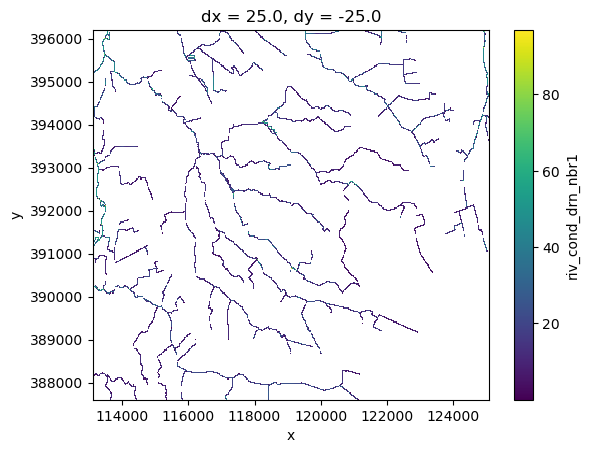

In [124]:
A_key = list(d_Pa_Cond.keys())[1]
A_whole = d_Pa_Cond[A_key]
A = A_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(A_key)
A.plot.imshow()

RIV_Cond_DETAILWATERGANGEN_NBr1.IDF


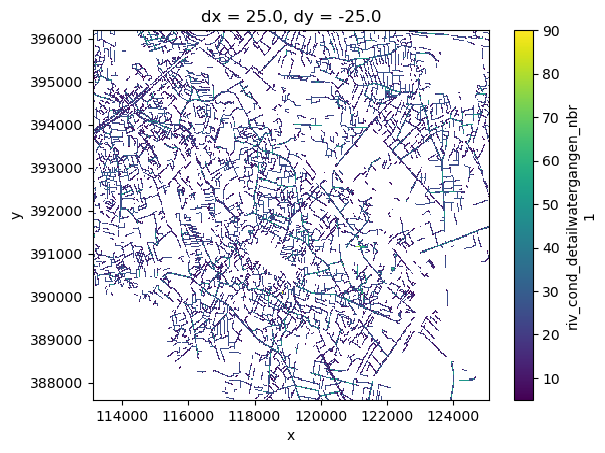

In [125]:
B_key = list(d_Pa_Cond.keys())[0]
B_whole = d_Pa_Cond[B_key]
B = B_whole.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
print(B_key)
B.plot.imshow()

We've loaded the main RIV cond as A, and the detailed as B. We'll use the average for now.

Union array C: 38659 valid values, sum = 797031.0


Text(0.5, 1.0, 'Array C: Union of A and B')

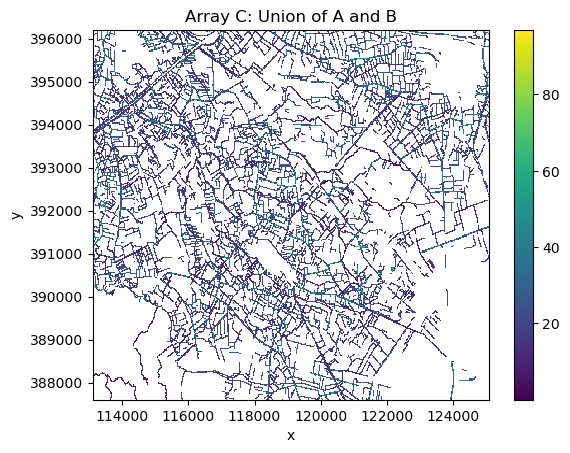

In [126]:
# Create union array C: average where both valid, single value where only one valid
C = xr.where(~np.isnan(A) & ~np.isnan(B), (A + B) / 2,  # Both valid: average
             xr.where(~np.isnan(A), A, B))                # Only one valid: use that one

print(f"Union array C: {(~np.isnan(C)).sum().values} valid values, sum = {C.sum(skipna=True).values}")
C.plot.imshow()
plt.title('Array C: Union of A and B')

In [127]:
DF_RC['RIV_Cond'] = DF_RC['Cond'].copy() # Apply conductance matching to DF_RC using array C. Start with copy of existing Cond values as fallback

C_DF_RC = C.values[DF_RC['i'].values, DF_RC['j'].values] # Get array values for all i,j coordinates at once (vectorized)

In [128]:
# Replace only where array has valid (non-NaN) values
valid_mask_RC = ~np.isnan(C_DF_RC)
DF_RC.loc[valid_mask_RC, 'RIV_Cond'] = C_DF_RC[valid_mask_RC]

In [129]:
print(f"DF_RC conductance matching results:")
print(f"Replaced {valid_mask_RC.sum()} values out of {len(DF_RC)} total rows ({valid_mask_RC.sum()/len(DF_RC)*100:.1f}%)")
print(f"Original Cond: min={DF_RC['Cond'].min():.3f}, max={DF_RC['Cond'].max():.3f}")
print(f"New RIV_Cond: min={DF_RC['RIV_Cond'].min():.3f}, max={DF_RC['RIV_Cond'].max():.3f}")

# Check how many values actually changed
changed_values_RC = (DF_RC['Cond'] != DF_RC['RIV_Cond'])
print(f"Values that changed: {changed_values_RC.sum()} out of {len(DF_RC)}")

DF_RC conductance matching results:
Replaced 7596 values out of 7819 total rows (97.1%)
Original Cond: min=6.507, max=5335.576
New RIV_Cond: min=0.036, max=3149.593
Values that changed: 7596 out of 7819


In [130]:
DF_RC['K_RIV'] = DF_RC['RIV_Cond'] * DF_RC['strthick'] / (DF_RC['width'] * DF_RC['rchlen'])

In [131]:
DF_RC['Cond_Diff'] = DF_RC['RIV_Cond'] - DF_RC['Cond']

In [132]:
DF_RC.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [133]:
DF_reach['strhc1'] = DF_RC['K_RIV'] # Set it back to DF_reach

### 3.2.5 Explore segments

In [134]:
DF_Sgm = SFR_data.segment_data.copy()

In [135]:
DF_Sgm.iloc[:].describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Most columns aren't interesting. Let's plot the interesting ones.

In [136]:
DF_Sgm[["nseg", "outseg", "roughch", "elevup", "elevdn", "width1", "width2", ]]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [137]:
(DF_Sgm['width1'] == DF_Sgm['width1']).all()

np.True_

In [138]:
(DF_Sgm['elevup'] >= DF_Sgm['elevdn']).all()

np.True_

We can see:
- the roughness values are all the same (default) - **OK**
- downstream elevation is always lower than (or equal to) upstream - **OK**
- the widths seem to be the ones read from the shapefile - **OK**

### 3.2.6 Add OBS

In [139]:
help(SFR_data.add_observations)

Help on method add_observations in module sfrmaker.sfrdata:

add_observations(
    data,
    flowline_routing=None,
    obstype=None,
    sfrlines_shapefile=None,
    x_location_column=None,
    y_location_column=None,
    line_id_column=None,
    rno_column=None,
    obstype_column=None,
    obsname_column='site_no',
    gage_starting_unit_number=250
) method of sfrmaker.sfrdata.SFRData instance



In [142]:
Pa_SFR_OBS_In = PJ(d_Pa['In'], f'OBS/SFR/NBr35/NBr35_SFR_OBS_Pnt.csv') #666 Should be PJ(d_Pa['In'], f'OBS/SFR/{MdlN}/{MdlN}_SFR_OBS_Pnt.csv')
DF_SFR_OBS = pd.read_csv(Pa_SFR_OBS_In)
DF_SFR_OBS

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [143]:
for i, row in DF_SFR_OBS.iterrows(): # Have to add them one by one, otherwise it groups them by reach and only keeps the 1st one. This is an SFRmaker bug, I can fix that later and make a pull request.
    SFR_data.add_observations(
        pd.DataFrame(row).T,
        x_location_column='x',  
        y_location_column='y',
        obstype_column='obstype',
        obsname_column='site_no'
        )

In [144]:
SFR_data.observations

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### 3.2.7 Run diagnostics

In [145]:
SFR_data.run_diagnostics(verbose=True)


Running Flopy v. 3.9.5 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or modelgrid object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
565 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
0	280	392	1	1	9.055564880371094	1.0	1.0
0	281	392	1	2	1.7061779499053955	1.0	1.0
0	281	392	2	1	4.667040824890137	1.0	1.0
0	280	392	2	2	14.092729568481445	1.0	1.0
0	273	371	2	29	24.60301971435547	1.0	1.0
0	277	342	3	11	14.557782173156738	1.0	1.0
0	273	371	4	1	1.6739485263824463	1.0	1.0
0	265	346	4	34	14.943877220153809	1.0	1.0
0	264	346	4	35	5.178472995758057	1.0	1.0
0	277	342	5	1	12.344932556152344	1.0	1.0
0	267	343	5	19	3.

Most checks passed, except for:
1. Checking reach_data for downstream rises in streambed elevation...<br>68 reaches encountered with strtop < strtop of downstream reach. Let's see if this causes a problem.
2. Checking for model cells with multiple non-zero SFR conductances...
565 model cells with multiple non-zero SFR conductances found.
This can be fixed easily with one of the SFRdata options. We'll come here if it causes an error in the Sim.
3. floppy Mdl not connected to SFRdata means:<br>
    3.1 Cannot check reach proximities
    3.2 Cannot check streambed elevations against cell bottom elevations. This shouldn't be a problem as the assign_layers function uses strbedthck (to assign k).


In [146]:
GDF_Elv.loc[ GDF_Elv['D'] - GDF_Elv['B_'] < 0]

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


There are fewer entries in the GDF_Elv where the DStr Elv > UStr Elv, but this DF contains segments, not reaches. So this is expected.

## 3.3 Write file and add to NAM

In [147]:
SFR_data.reach_data = DF_reach

In [148]:
SFR_data.write_package(d_Pa['SFR'], version='mf6')

SFRmaker v. 0.12.1

Running Flopy v. 3.9.5 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or modelgrid object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
565 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
4	280	392	1	1	9.055564880371094	0.10000000149011612	0.15277858078479767
4	281	392	1	2	1.7061779499053955	0.10000000149011612	0.23171675205230713
4	281	392	2	1	4.667040824890137	0.10000000149011612	0.08471106737852097
4	280	392	2	2	14.092729568481445	0.10000000149011612	0.0981709286570549
4	273	371	2	29	24.60301971435547	0.10000000149011612	0.08490876108407974
4	277	342	3	11	14.557782173156738	0.1000000014

In [149]:
# Try to find an inteernal SFRmaker way to fix this later. This is just a temporary patch.
with open(d_Pa['SFR'], 'r+', encoding='cp1252') as f:
    content = f.read()
    content = content.replace(f"FILEIN {MdlN}.SFR6.obs", f"FILEIN imported_model/{MdlN}.SFR6.obs")
    content = content.replace('BUDGET FILEOUT', '#BUDGET FILEOUT')
    f.seek(0)
    f.truncate()
    f.write(content)

In [150]:
os.rename('model_SFR.chk', PJ(d_Pa['MF6'], 'imported_model/model_SFR.chk'))

In [151]:
with open(d_Pa['NAM_Mdl'], 'r') as f1:
    l_Lns_NAM = f1.readlines()  

In [152]:
l_Lns_NAM.insert(-1, f"  sfr6 imported_model/{PBN(d_Pa['SFR'])} sfr\n")

In [153]:
with open(d_Pa['NAM_Mdl'], 'w') as f2:
    f2.writelines(l_Lns_NAM)

# 4. Connect DRN to SFR

## 4.1 Attempt 1 - load DRN from previous Sim

In [ ]:
# d_DRN_Pa = [r'C:\OD\WS_Mdl\models\NBr\Sim\NBr18\GWF_1\MODELINPUT\DRN6\SYS1\DRN_T1.ARR',
#             r'C:\OD\WS_Mdl\models\NBr\Sim\NBr18\GWF_1\MODELINPUT\DRN6\SYS3\DRN_T1.ARR',]

In [ ]:
# def plot_DRN(A_DRN):
#     # Plot A_DRN elevation and conductance
#     fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#     # Plot elevation
#     A_DRN['elevation'].plot(ax=axes[0], cmap='viridis', 
#                             cbar_kwargs={'label': 'Elevation (m)'})
#     axes[0].set_title('A_DRN Elevation')
#     axes[0].set_aspect('equal')

#     # Plot conductance
#     A_DRN['conductance'].plot(ax=axes[1], cmap='plasma',
#                             cbar_kwargs={'label': 'Conductance (1/d)'})
#     axes[1].set_title('A_DRN Conductance')
#     axes[1].set_aspect('equal')

#     plt.tight_layout()
#     plt.show()

#     # Print some basic statistics
#     print(f"\nA_DRN Elevation stats:")
#     print(f"Min: {A_DRN['elevation'].min().values:.2f}")
#     print(f"Max: {A_DRN['elevation'].max().values:.2f}")
#     print(f"Valid values: {(~np.isnan(A_DRN['elevation'])).sum().values}")

#     print(f"\nA_DRN Conductance stats:")
#     print(f"Min: {A_DRN['conductance'].min().values:.2f}")
#     print(f"Max: {A_DRN['conductance'].max().values:.2f}")
#     print(f"Valid values: {(~np.isnan(A_DRN['conductance'])).sum().values}")

In [ ]:
# d_A_DRN = {i: MF6_Mdl.data[i].dataset.isel(layer=0, time=0).sel() for i in MF6_Mdl.data.keys() if 'drn' in i.lower()}

In [ ]:
# for i in d_A_DRN.keys():
#     print(f"\n--- DRN Package: {i} ---")
#     plot_DRN(d_A_DRN[i])

## 4.2 Attempt 2 - load DRN from current Sim
This is much better, as we can directly connect the items...

if it works... AI just mushed up some shit.

In [ ]:
# base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
# folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
# d_DRN_Pa = [PJ(base, folder, fname)
#              for folder in folders
#              for fname in os.listdir(PJ(base, folder))
#              if os.path.isfile(PJ(base, folder, fname))]

# d_DRN_Pa  # list of full paths to files inside the matched "drn" folders

In [ ]:
# # Read binary files from d_DRN_Pa to d_DRN_Bin
# # Keys should be the number following drn-
# import numpy as np
# import struct

# d_DRN_Bin = {}

# for file_path in d_DRN_Pa:
#     # Extract filename from path
#     filename = os.path.basename(file_path)
#     folder_name = os.path.basename(os.path.dirname(file_path))
    
#     print(f"Processing: {filename} from folder: {folder_name}")
    
#     # Extract key from folder name (drn-1, drn-2, etc.)
#     key_found = False
    
#     # Look for drn- pattern in folder name first
#     if 'drn-' in folder_name.lower() or 'drn_' in folder_name.lower():
#         separator = 'drn-' if 'drn-' in folder_name.lower() else 'drn_'
#         parts = folder_name.lower().split(separator)
#         if len(parts) > 1:
#             number_part = parts[1]
            
#             # Extract only the numeric part
#             import re
#             match = re.match(r'^(\d+)', number_part)
#             if match:
#                 key = int(match.group(1))
#                 key_found = True
    
#     # If not found in folder, try filename
#     if not key_found:
#         for name_source in [filename.lower()]:
#             if 'drn-' in name_source or 'drn_' in name_source:
#                 separator = 'drn-' if 'drn-' in name_source else 'drn_'
#                 parts = name_source.split(separator)
#                 if len(parts) > 1:
#                     number_part = parts[1].split('.')[0]  # Remove file extension
                    
#                     import re
#                     match = re.match(r'^(\d+)', number_part)
#                     if match:
#                         key = int(match.group(1))
#                         key_found = True
#                         break
    
#     if not key_found:
#         print(f"  Could not extract key from {filename} or {folder_name}")
#         continue
    
#     try:
#         # Read the binary file
#         with open(file_path, 'rb') as f:
#             data = f.read()
            
#         # Store the data with metadata
#         d_DRN_Bin[key] = {
#             'file_path': file_path,
#             'filename': filename,
#             'folder': folder_name,
#             'size': len(data),
#             'raw_data': data
#         }
        
#         print(f"  Successfully loaded {filename} with key {key} (size: {len(data)} bytes)")
        
#     except Exception as e:
#         print(f"  Error reading {filename}: {e}")

# print(f"\nLoaded {len(d_DRN_Bin)} binary files")
# print(f"Keys: {sorted(d_DRN_Bin.keys())}")

# # Display summary
# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     print(f"Key {key}: {info['filename']} from {info['folder']} ({info['size']} bytes)")

In [ ]:
# # Helper function to access binary data
# def get_drn_binary_data(key):
#     """Get the raw binary data for a specific DRN key"""
#     if key in d_DRN_Bin:
#         return d_DRN_Bin[key]['raw_data']
#     else:
#         raise KeyError(f"Key {key} not found in d_DRN_Bin. Available keys: {list(d_DRN_Bin.keys())}")

# # Example usage:
# print("Available DRN binary files:")
# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     print(f"  Key {key}: {info['filename']} ({info['size']:,} bytes)")
    
# print(f"\nExample: To access binary data for key 1: get_drn_binary_data(1)")
# print(f"Example: Direct access to metadata: d_DRN_Bin[1]['file_path']")

In [ ]:
# # These are likely MODFLOW6 binary budget files - use flopy's correct method
# import flopy.utils as fpu

# d_DRN_Readable = {}

# for key in sorted(d_DRN_Bin.keys()):
#     info = d_DRN_Bin[key]
#     file_path = info['file_path']
    
#     try:
#         # Try as MODFLOW6 binary budget file
#         budget = fpu.CellBudgetFile(file_path)
#         records = budget.get_unique_record_names()
#         times = budget.get_times()
        
#         d_DRN_Readable[key] = {
#             'filename': info['filename'],
#             'folder': info['folder'],
#             'budget_file': budget,
#             'records': records,
#             'times': times,
#             'summary': f"DRN-{key}: Budget file with {len(records)} records, {len(times)} time steps"
#         }
        
#         print(f"Key {key}: {d_DRN_Readable[key]['summary']}")
#         print(f"  Records: {records}")
        
#     except Exception as e:
#         print(f"Key {key}: Failed - {e}")

# print(f"\nSuccessfully read {len(d_DRN_Readable)} DRN budget files")

In [ ]:
# # Check what we actually have
# print("d_DRN_Bin keys:", list(d_DRN_Bin.keys()) if 'd_DRN_Bin' in globals() else "Not found")
# print("d_DRN_Readable keys:", list(d_DRN_Readable.keys()) if 'd_DRN_Readable' in globals() else "Not found")
# print("d_DRN_Readable contents:", d_DRN_Readable if 'd_DRN_Readable' in globals() else "Not found")

# # If empty, let's create a simple readable version
# if not d_DRN_Readable and 'd_DRN_Bin' in globals():
#     print("\\nCreating simple readable format...")
#     d_DRN_Readable = {}
#     for key in d_DRN_Bin.keys():
#         d_DRN_Readable[key] = f"DRN file {key}: {d_DRN_Bin[key]['filename']} ({d_DRN_Bin[key]['size']/1024/1024:.1f} MB)"
    
#     print("Success! d_DRN_Readable now contains:", d_DRN_Readable)

In [ ]:
# ## Accessing File Contents

# #You can access the binary file contents in several ways:

# # How to access file contents from d_DRN_Bin

# # 1. Access raw binary data directly
# print("Raw binary data for file 1 (first 100 bytes):")
# print(d_DRN_Bin[1]['raw_data'][:100])

# # 2. Get file information
# print("\nFile information:")
# for key in d_DRN_Bin:
#     info = d_DRN_Bin[key]
#     print(f"File {key}: {info['filename']} from {info['folder']}")
#     print(f"  Full path: {info['file_path']}")
#     print(f"  Size: {info['size']} bytes ({info['size']/1024/1024:.1f} MB)")
#     print(f"  Raw data length: {len(info['raw_data'])} bytes")
#     print()

# # 3. Access the actual binary content for processing
# for key in [1, 2, 3]:
#     raw_bytes = d_DRN_Bin[key]['raw_data']
#     print(f"File {key} - First 20 bytes as hex: {raw_bytes[:20].hex()}")
#     print(f"File {key} - First 20 bytes as text (try): {raw_bytes[:20]}")
#     print()

In [ ]:
# # Check the actual structure of d_DRN_Bin
# print("Structure of d_DRN_Bin:")
# for key in d_DRN_Bin:
#     print(f"Key {key}: {type(d_DRN_Bin[key])}")
#     if isinstance(d_DRN_Bin[key], dict):
#         print(f"  Keys in dictionary: {list(d_DRN_Bin[key].keys())}")
#     else:
#         print(f"  Direct content type: {type(d_DRN_Bin[key])}")
#         print(f"  Content length: {len(d_DRN_Bin[key])} bytes")
#         print(f"  First 50 bytes: {d_DRN_Bin[key][:50]}")
#     print()

In [ ]:
# d_DRN_Bin[1]

In [ ]:
# print(d_DRN_Readable)

## 4.3 Attempt #3
With some help from Chat GPT

In [154]:
base = PJ(d_Pa['Pa_MdlN'], 'modflow6/imported_model')
folders = [f for f in os.listdir(base) if ('drn' in f.lower()) and not ('.' in f) and os.path.isdir(PJ(base, f))]
l_DRN_Pa = [PJ(base, folder, fname)
             for folder in folders
             for fname in os.listdir(PJ(base, folder))
             if os.path.isfile(PJ(base, folder, fname))]

l_DRN_Pa  # list of full paths to files inside the matched "drn" folders

['C:/OD/WS_Mdl\\models/NBr\\Sim/NBr36\\modflow6/imported_model\\drn-1\\drn-0.bin',
 'C:/OD/WS_Mdl\\models/NBr\\Sim/NBr36\\modflow6/imported_model\\drn-2\\drn-0.bin',
 'C:/OD/WS_Mdl\\models/NBr\\Sim/NBr36\\modflow6/imported_model\\drn-3\\drn-0.bin']

In [222]:
def read_mf6_drn_bin(filepath: str | Path) -> pd.DataFrame:
    """Read MODFLOW 6 DRN binary input (imod format) into a DataFrame."""
    dtype = np.dtype([
        ("k",    "<i4"),   # layer
        ("i",    "<i4"),   # row
        ("j",    "<i4"),   # column
        ("elev", "<f8"),   # elevation
        ("cond", "<f8"),   # conductance
    ])
    path = Path(filepath)
    nrec = path.stat().st_size // dtype.itemsize
    arr = np.fromfile(path, dtype=dtype, count=nrec)
    return pd.DataFrame(arr)

In [223]:
d_DRN_DF = {}

for i in range(len(l_DRN_Pa)):
    DF_DRN = read_mf6_drn_bin(l_DRN_Pa[i])
    d_DRN_DF[int(re.search(r'(?i)drn[-_]?(\d+)', PDN(l_DRN_Pa[i])).group(1))] = DF_DRN.loc[ ~DF_DRN['i'].isin([1, N_R]) & ~DF_DRN['j'].isin([1, N_C]) ]

In [224]:
for k in d_DRN_DF.keys():
    print(f"DRN-{k} DataFrame shape: {d_DRN_DF[k].shape}")
    d_DRN_DF[k] = U.Calc_DF_XY(d_DRN_DF[k], X_Ogn, Y_Ogn, cellsize)
    d_DRN_DF[k].drop(columns=['cond', 'elev'], inplace=True)
    d_DRN_DF[k]['Pkg1'] = f'drn-{k}'
    d_DRN_DF[k]['Pvd_Id'] = d_DRN_DF[k].index + 1  # 1-based index

DRN-1 DataFrame shape: (16421, 5)
DRN-2 DataFrame shape: (163476, 5)
DRN-3 DataFrame shape: (8900, 5)


In [226]:
DF_reach_for_DRN = U.Calc_DF_XY(DF_reach[['rno', 'i', 'j']], X_Ogn, Y_Ogn, cellsize)

In [232]:
# Combine all DRN DataFrames and match with reach points by minimum distance
from scipy.spatial.distance import cdist

# Combine all d_DRN_DF items into a single DataFrame  
DF_DRN_all = pd.concat(d_DRN_DF.values(), ignore_index=True)

# Calculate distances and find closest reach for each DRN point
drn_coords = DF_DRN_all[['X', 'Y']].values
reach_coords = DF_reach_for_DRN[['X', 'Y']].values
distances = cdist(drn_coords, reach_coords, metric='euclidean')
min_indices = np.argmin(distances, axis=1)

# Add matched reach data to DRN DataFrame
matched_reach_data = DF_reach_for_DRN.iloc[min_indices].reset_index(drop=True)
DF_DRN_all_matched = DF_DRN_all.copy()
DF_DRN_all_matched['matched_rno'] = matched_reach_data['rno'].values
DF_DRN_all_matched['distance_to_match'] = distances[np.arange(len(drn_coords)), min_indices]

print(f"Combined {len(DF_DRN_all):,} DRN points from {len(d_DRN_DF)} DataFrames")
print(f"Matched to {DF_DRN_all_matched['matched_rno'].nunique()} unique reaches")
print(f"Mean distance: {DF_DRN_all_matched['distance_to_match'].mean():.0f}m")

Combined 188,797 DRN points from 3 DataFrames
Matched to 7074 unique reaches
Mean distance: 339m


In [233]:
# Quick summary of matching results
print(f"Results: {len(DF_DRN_all_matched):,} DRN points matched")
print(f"Distance stats: mean={DF_DRN_all_matched['distance_to_match'].mean():.0f}m, "
      f"perfect_matches={(DF_DRN_all_matched['distance_to_match'] == 0).sum():,}")
print(DF_DRN_all_matched[['k', 'i', 'j', 'X', 'Y', 'Pkg1', 'matched_rno', 'distance_to_match']].head())

Results: 188,797 DRN points matched
Distance stats: mean=339m, perfect_matches=7,520
   k  i    j         X         Y   Pkg1  matched_rno  distance_to_match
0  1  2    2  113137.5  396162.5  drn-1         7448         291.547595
1  1  2    3  113162.5  396162.5  drn-1         7448         270.416346
2  1  2    4  113187.5  396162.5  drn-1         7448         250.000000
3  1  2    5  113212.5  396162.5  drn-1         7448         230.488611
4  1  2  144  116687.5  396162.5  drn-1         6049         201.556444


# 5. Execute model

In [ ]:
# with open(d_Pa['TOML'], 'a') as f: # Add enable_sprinkling = true to the end of the TOML file
#     f.write('enable_sprinkling = true\n')

In [ ]:
U.mete_grid_add_missing_Cols(PJ(d_Pa['Pa_MdlN'], 'metaswap/mete_grid.inp'))

In [ ]:
stop

In [ ]:
# Execute the coupled model
print("🚀 Starting coupled model execution...")
print(f"Model directory: {d_Pa['Pa_MdlN']}")

# Check what files were written
print("\n📁 Checking written model files:")
if PE(d_Pa['Pa_MdlN']):
    model_files = LD(d_Pa['Pa_MdlN'])
    for file in sorted(model_files):
        print(f"  - {file}")
    
    # Look for the main execution file (usually .toml or similar)
    toml_files = [f for f in model_files if f.endswith('.toml')]
    if toml_files:
        print(f"\n🎯 Found TOML configuration file: {toml_files[0]}")
        main_toml = PJ(d_Pa['Pa_MdlN'], toml_files[0])
        
        # Since we have the DLL paths, we can try to execute using the iMOD coupler
        # The iMOD coupler typically needs the .toml file as input
        coupler_exe = Pa_IMC
        
        if PE(coupler_exe):
            print(f"✅ Found iMOD coupler: {coupler_exe}")
            print(f"🔄 Executing: {coupler_exe} {main_toml}")
            
            # Execute the model (this will take some time)
            import subprocess
            try:
                result = subprocess.run([coupler_exe, main_toml], 
                                      cwd=d_Pa['Pa_MdlN'], 
                                      capture_output=True, 
                                      text=True,
                                      timeout=3600)  # 1 hour timeout
                
                print(f"Return code: {result.returncode}")
                if result.stdout:
                    print("STDOUT:")
                    print(result.stdout)
                if result.stderr:
                    print("STDERR:")
                    print(result.stderr)
                    
                if result.returncode == 0:
                    print("✅ Model execution completed successfully!")
                else:
                    print(f"❌ Model execution failed with return code {result.returncode}")
                    
            except subprocess.TimeoutExpired:
                print("⏰ Model execution timed out after 1 hour")
            except Exception as e:
                print(f"❌ Error executing model: {e}")
        else:
            print(f"❌ iMOD coupler not found at: {coupler_exe}")
            print("You may need to execute the model manually using the iMOD coupler")
    else:
        print("❌ No TOML configuration file found")
else:
    print(f"❌ Model directory not found: {d_Pa['Pa_MdlN']}")

Model executed sucessfully!!! More improvements next Sim (NBr35).

# -1. Junkyard

In [ ]:
# # Create flopy MF6 model with DIS package from existing MF6_DIS
# def create_flopy_model_from_imod_dis(mf6_dis, model_name="gwf_model"):
#     """
#     Convert imod MF6_DIS to flopy MF6 model with DIS package
#     """
#     # Extract data from imod DIS
#     dataset = mf6_dis.dataset
#     nlay, nrow, ncol = dataset.dims['layer'], dataset.dims['y'], dataset.dims['x']
#     dx = abs(float(dataset.coords['dx'].values))
#     dy = abs(float(dataset.coords['dy'].values))
    
#     # Get elevation arrays
#     top_array = dataset['top'].values
#     bottom_array = dataset['bottom'].values
#     idomain_array = dataset['idomain'].values
    
#     # Calculate grid origin 
#     x_coords = dataset.coords['x'].values
#     y_coords = dataset.coords['y'].values
#     xorigin = x_coords[0] - dx/2
#     yorigin = y_coords[-1] - dy/2
    
#     # Create flopy simulation
#     model_ws = "flopy_model"
#     os.makedirs(model_ws, exist_ok=True)
    
#     sim = mf6.MFSimulation(sim_name="mf6_sim", sim_ws=model_ws, exe_name='mf6')
#     tdis = mf6.ModflowTdis(sim, nper=1, perioddata=[(1.0, 1, 1.0)])
#     ims = mf6.ModflowIms(sim, print_option='ALL')
    
#     # Create groundwater flow model
#     gwf = mf6.MFModel(simulation=sim, model_type='gwf6', modelname=model_name)
    
#     # Create DIS package
#     dis = mf6.ModflowGwfdis(
#         gwf,
#         nlay=nlay, nrow=nrow, ncol=ncol,
#         delr=dx, delc=dy,
#         top=top_array,
#         botm=bottom_array,
#         idomain=idomain_array,
#         xorigin=xorigin,
#         yorigin=yorigin
#     )
    
#     print(f"✓ Created flopy MF6 model with DIS:")
#     print(f"  - Grid: {nlay} layers, {nrow} rows, {ncol} cols")
#     print(f"  - Cell size: {dx} x {dy} m")
#     print(f"  - Origin: ({xorigin:.0f}, {yorigin:.0f})")
#     print(f"  - Workspace: {model_ws}")
    
#     return sim, gwf, dis

# # Create flopy model
# sim, gwf, dis = create_flopy_model_from_imod_dis(MF6_DIS)

# # Access the flopy grid object
# flopy_grid = gwf.modelgrid
# print(f"\\n✓ Flopy StructuredGrid created:")
# print(f"  - Shape: {flopy_grid.shape}")
# print(f"  - Extent: {flopy_grid.extent}")
# print(f"  - Grid ready for use with flopy tools!")

In [ ]:
# # Create proper metadata dictionary for all 37 layers
# n_layers = DS.bottom.shape[0]  # Should be 37
# d_MtDt_bottom = {}

# # Add metadata for each layer
# for i in range(n_layers):
#     layer_num = i + 1  # 1-based layer numbering
#     d_MtDt_bottom[f'layer_{layer_num:02d}'] = {
#         'layer': f'L{layer_num}',
#         'description': f'Bottom elevation for layer {layer_num}',
#         'units': 'm'
#     }

# # Add global metadata
# d_MtDt_bottom['all'] = {
#     'metadata': f"Created on {DT.today().strftime('%Y-%m-%d %H:%M:%S')}, to sense check SFRmaker's calculated Ls against the real grid. 100x100 gets interpolated.",
#     'source': 'DS.bottom',
#     'total_layers': n_layers
# }

# print(f"Creating TIF with {n_layers} bands...")
# print(f"Metadata keys: {len([k for k in d_MtDt_bottom.keys() if k != 'all'])} bands")

# # Now call the function with proper metadata
# G.DA_to_MBTIF(
#     DS.bottom, 
#     r"C:\OD\WS_Mdl\models\NBr\PoP\In\BOT\NBr1\BOT_NBr1_25x25.tif", 
#     d_MtDt_bottom, 
#     crs=G.crs, 
#     _print=True
# )

##### k=0 investigation

In [ ]:
# print(f"SFR Grid dimensions: {SFR_grid.nrow} rows × {SFR_grid.ncol} cols")
# print(f"Max node in reach data: {DF_reach['node'].max()}")
# print(f"Expected max node for 2D grid: {SFR_grid.nrow * SFR_grid.ncol - 1}")
# print(f"Max i in reach data: {DF_reach['i'].max()}")
# print(f"Max j in reach data: {DF_reach['j'].max()}")

**Why is SFRmaker doing this incorrect conversion?**

The issue is in SFRmaker's source code (`sfrmaker/lines.py` around lines 356-372). 

**The Problem:**
- SFRmaker hardcodes `k = 0` for all reaches 
- It assumes all node numbers are **2D nodes** (layer 0 only)
- It uses 2D conversion formulas: `i = node ÷ ncol` and `j = node % ncol`

**What's happening in your case:**
- Your model has **3D nodes** that include layer information
- SFRmaker receives 3D node numbers (like 1,155,680) 
- It incorrectly applies 2D conversion to these 3D nodes
- This gives wrong `i` values (like 2,407 instead of proper row indices 0-343)

**The correct 3D conversion should be:**
- `k = node ÷ (nrow × ncol)`
- `i = (node % (nrow × ncol)) ÷ ncol` 
- `j = node % ncol`

This is a bug in SFRmaker - it doesn't handle 3D structured grids properly.

In [ ]:
# # Let's demonstrate the problem with a few example nodes from your data
# import numpy as np

# # Get some example 3D nodes from your reach data
# example_nodes = DF_reach['node'].iloc[::10000].tolist()[:5]  # Every 10000th node, first 5
# print("Example 3D nodes from your data:", example_nodes)
# print()

# # Grid dimensions
# nrow, ncol = SFR_grid.nrow, SFR_grid.ncol  # 344, 480
# print(f"Grid: {nrow} rows × {ncol} cols")
# print()

# # Show what SFRmaker is doing (INCORRECT for 3D nodes)
# print("❌ SFRmaker's INCORRECT 2D conversion:")
# for node in example_nodes:
#     i_wrong = node // ncol  # SFRmaker's approach
#     j = node % ncol
#     k = 0  # SFRmaker hardcodes this
#     print(f"  Node {node:>7} → k={k}, i={i_wrong:>4}, j={j:>3}")
# print()

# # Show what the CORRECT 3D conversion should be
# print("✅ CORRECT 3D conversion:")
# for node in example_nodes:
#     k_correct = node // (nrow * ncol)
#     i_correct = (node % (nrow * ncol)) // ncol
#     j_correct = node % ncol
#     print(f"  Node {node:>7} → k={k_correct}, i={i_correct:>3}, j={j_correct:>3}")
    
# print(f"\n📊 Your data statistics:")
# print(f"   Max i in data: {DF_reach['i'].max()} (should be ≤ {nrow-1})")
# print(f"   Max j in data: {DF_reach['j'].max()} (should be ≤ {ncol-1}) ✓")

##### testing relics

In [ ]:
#N_L, N_R, N_C, f"{N_L * N_R * N_C:,}"

In [ ]:
#DF_reach['node'].describe()

In [ ]:
# DF_reach['i_copy'] = DF_reach['i'].copy()
# DF_reach['k_copy'] = DF_reach['k'].copy()

In [ ]:
# DF_reach['test'] = (DF_reach['i_copy'] % (DF_reach['k'] * DF_reach['j']))
# DF_reach[['node', 'k', 'i', 'j', 'test']].head(20)

In [ ]:
# DF_test = DF_reach[['node', 'k', 'i_copy', 'j']].copy()

In [ ]:
# DF_test['k_a'] = DF_reach['node'] // (N_R * N_C)
# DF_test['k_b'] = DF_reach['i_copy'] % (N_R *

#### Co-pilot assign layer error investigation

In [ ]:
# # Let's look for the exact case from the previous output
# # From cell 173 output, we saw k=6, i=281, j=392 with strtop=19.759
# test_case = DF_reach[(DF_reach['strtop'] > 19.75) & (DF_reach['strtop'] < 19.77)]
# print("Found test cases with strtop around 19.76:")
# print(test_case[['k', 'i', 'j', 'strtop', 'strthick', 'rno']].head())

# if len(test_case) > 0:
#     # Take the first match
#     k, i, j, strtop, strthick = test_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
#     strbot_calculated = strtop - strthick
#     print(f"\nAnalyzing case: k={k}, i={i}, j={j}")
#     print(f"strtop: {strtop}")
#     print(f"strthick: {strthick}")
#     print(f"strbot (strtop - strthick): {strbot_calculated}")
    
#     # Get the BOTs at this location (using 0-based indexing)
#     print(f"\nLayer bottoms at i={i}, j={j}:")
#     for L in range(min(10, BOTs.shape[0])):  # Show first 10 layers
#         bot = BOTs[L, i, j]
#         print(f"L{L+1} bottom: {bot:.6f}")
        
#     # Let's check what layer the reach was actually assigned to
#     assigned_k = reach_Ls[test_case.index[0]]
#     print(f"\nReach was assigned to layer k={assigned_k+1} (1-based) = k={assigned_k} (0-based)")
    
#     # Check where strbot should be assigned
#     print(f"\nAnalyzing where strbot ({strbot_calculated:.6f}) should be assigned:")
#     for L in range(min(8, BOTs.shape[0]-1)):  # Check first 8 layers
#         if L == 0:
#             top = TOPs[0, i, j]  # First layer top - TOPs is 3D like BOTs
#         else:
#             top = BOTs[L-1, i, j]  # Previous layer bottom = current layer top
#         bot = BOTs[L, i, j]
#         fits = bot <= strbot_calculated <= top
#         print(f"L{L+1}: top={top:.6f}, bot={bot:.6f} - strbot fits? {fits}")
#         if fits:
#             print(f"  --> Stream bottom SHOULD be in Layer {L+1} (0-based: {L})")
#             if L != assigned_k:
#                 print(f"  *** PROBLEM: But it was assigned to Layer {assigned_k+1} (0-based: {assigned_k}) ***")
#             break
    
#     # Let's also test what happens if we use strthick=1.0 instead of 0.1
#     strbot_with_thick_1 = strtop - 1.0
#     print(f"\nIf strthick was 1.0 instead of 0.1:")
#     print(f"strbot would be: {strbot_with_thick_1:.6f}")
#     for L in range(min(8, BOTs.shape[0]-1)):
#         if L == 0:
#             top = TOPs[0, i, j]
#         else:
#             top = BOTs[L-1, i, j]
#         bot = BOTs[L, i, j]
#         fits = bot <= strbot_with_thick_1 <= top
#         if fits:
#             print(f"  --> With strthick=1.0, would be assigned to Layer {L+1} (0-based: {L})")
#             if L == assigned_k:
#                 print(f"  *** This matches the actual assignment! The function may be ignoring strthick=0.1 ***")
#             break
# else:
#     print("No test case found.")

In [ ]:
# # Let's test the assign_layers function more systematically
# # Create a small test case to verify if it's using strthick properly

# print("=== TESTING sfr.utils.assign_layers BEHAVIOR ===")
# print()

# # Create a minimal test dataframe with known values
# test_df = DF_reach.iloc[3910:3912].copy()  # Take the problematic cases
# print("Test data:")
# print(test_df[['k', 'i', 'j', 'strtop', 'strthick']])
# print()

# # Test 1: Call with strthick = 0.1 (current values)
# print("Test 1: Using strthick = 0.1 (current values)")
# test_layers_01, _ = sfr.utils.assign_layers(reach_data=test_df, botm_array=BOTs)
# print("Assigned layers:", test_layers_01)
# print()

# # Test 2: Temporarily change strthick to 1.0 and see what happens
# test_df_thick1 = test_df.copy()
# test_df_thick1['strthick'] = 1.0
# print("Test 2: Changing strthick to 1.0")
# print(test_df_thick1[['k', 'i', 'j', 'strtop', 'strthick']])
# test_layers_10, _ = sfr.utils.assign_layers(reach_data=test_df_thick1, botm_array=BOTs)
# print("Assigned layers:", test_layers_10)
# print()

# # Test 3: What if we use a different column name?
# test_df_custom = test_df.copy()
# test_df_custom['custom_thick'] = 0.1
# print("Test 3: Using custom column name 'custom_thick'")
# test_layers_custom, _ = sfr.utils.assign_layers(reach_data=test_df_custom, botm_array=BOTs, strthick_col='custom_thick')
# print("Assigned layers:", test_layers_custom)
# print()

# print("=== ANALYSIS ===")
# print(f"With strthick=0.1: {test_layers_01}")
# print(f"With strthick=1.0: {test_layers_10}")
# print(f"With custom column: {test_layers_custom}")

# if np.array_equal(test_layers_01, test_layers_10):
#     print("❌ PROBLEM: strthick=0.1 and strthick=1.0 give SAME results!")
#     print("   This suggests the function is NOT using the strthick column.")
# elif np.array_equal(test_layers_01, test_layers_custom):
#     print("✅ The function DOES use the strthick column correctly.")
# else:
#     print("🤔 Mixed results - need further investigation.")

In [ ]:
# # Let's test specifically with the problematic case we found earlier
# print("=== TESTING THE SPECIFIC PROBLEMATIC CASE ===")

# # Get the exact case that was wrong
# problematic_case = DF_reach[(DF_reach['strtop'] > 19.75) & (DF_reach['strtop'] < 19.77)].iloc[[0]]
# print("Problematic case:")
# print(problematic_case[['k', 'i', 'j', 'strtop', 'strthick']])

# # Test it individually
# test_layer, _ = sfr.utils.assign_layers(reach_data=problematic_case, botm_array=BOTs)
# print(f"Function assigned layer: {test_layer} (0-based)")
# print(f"As scalar: {test_layer if np.isscalar(test_layer) else test_layer[0]} (0-based)")

# # Let's manually calculate what it should be
# k, i, j, strtop, strthick = problematic_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
# strbot = strtop - strthick

# print(f"\nManual calculation:")
# print(f"strtop: {strtop}")
# print(f"strthick: {strthick}")  
# print(f"strbot: {strbot}")

# # Find the correct layer manually
# for L in range(BOTs.shape[0]-1):
#     if L == 0:
#         top = TOPs[0, i, j]
#     else:
#         top = BOTs[L-1, i, j]
#     bot = BOTs[L, i, j]
    
#     if bot <= strbot <= top:
#         print(f"Manual calculation says layer should be: {L} (0-based)")
#         if L != (test_layer if np.isscalar(test_layer) else test_layer[0]):
#             print(f"❌ MISMATCH: Function returned {test_layer}, should be {L}")
#         else:
#             print(f"✅ MATCH: Function correctly returned {L}")
#         break

# # Let's also check if there might be a pad parameter affecting this
# print(f"\nLet's check what happens with different pad values:")
# for pad in [0.0, 1.0, 2.0]:
#     test_layer_pad, _ = sfr.utils.assign_layers(reach_data=problematic_case, botm_array=BOTs, pad=pad)
#     layer_val = test_layer_pad if np.isscalar(test_layer_pad) else test_layer_pad[0] 
#     print(f"With pad={pad}: layer = {layer_val}")

In [ ]:
# # Let's explore the logic behind the 'pad' parameter
# print("=== UNDERSTANDING THE 'pad' PARAMETER LOGIC ===")

# # From the documentation:
# # "Minimum distance that streambed bottom must be above layer bottom.
# #  When determining the layer or whether the streambed bottom is below
# #  the model bottom, streambed bottom - pad is used."

# k, i, j, strtop, strthick = problematic_case.iloc[0][['k', 'i', 'j', 'strtop', 'strthick']]
# strbot = strtop - strthick

# print(f"Example case: strtop={strtop:.3f}, strthick={strthick}, strbot={strbot:.3f}")
# print(f"\nLayer boundaries at this location:")

# for L in range(7):  # Show first 7 layers
#     if L == 0:
#         top = TOPs[0, i, j]
#     else:
#         top = BOTs[L-1, i, j]
#     bot = BOTs[L, i, j]
    
#     print(f"L{L+1}: top={top:.3f}, bot={bot:.3f}, thickness={top-bot:.3f}")
    
#     # Show what happens with different pad values
#     for pad in [0.0, 0.5, 1.0]:
#         effective_strbot = strbot - pad
#         fits = bot <= effective_strbot <= top
#         if fits:
#             print(f"  → With pad={pad}: effective_strbot={effective_strbot:.3f} fits in L{L+1}")

# print(f"\n=== WHY USE PAD? ===")
# print(f"1. NUMERICAL STABILITY: Prevents streams from being placed exactly on layer boundaries")
# print(f"2. HYDROGEOLOGICAL REALISM: Ensures minimum thickness between stream and impermeable layer")
# print(f"3. MODEL CONVERGENCE: Avoids numerical issues when stream and layer bottom are too close")
# print(f"4. SAFETY MARGIN: Accounts for elevation uncertainties in DEM/bathymetry data")

# print(f"\n=== PRACTICAL IMPLICATIONS ===")
# print(f"• pad=0.0: Stream can be right at layer bottom (risky for convergence)")
# print(f"• pad=1.0: Stream must be at least 1m above layer bottom (default, conservative)")
# print(f"• pad=0.1-0.5: Reasonable compromise for most applications")

# print(f"\n=== WHEN MIGHT YOU WANT DIFFERENT pad VALUES? ===")
# print(f"• High-resolution models (small cells): Use smaller pad (0.1-0.5m)")
# print(f"• Regional models (large cells): Default pad=1.0 is usually fine")
# print(f"• Very thin aquifers: May need smaller pad to allow streams in shallow layers")
# print(f"• Uncertain elevations: Larger pad for safety margin")

In [ ]:
# # Let's show a concrete example of why pad matters for model stability
# print("=== CONCRETE EXAMPLE: WHY pad PREVENTS PROBLEMS ===")

# print("Scenario: Stream bottom at 19.659m, Layer 5 bottom at 18.913m")
# print("Distance between stream bottom and layer bottom: {:.3f}m".format(19.659 - 18.913))

# print(f"\nWithout pad (pad=0.0):")
# print(f"• Stream bottom = 19.659m")
# print(f"• Layer bottom = 18.913m") 
# print(f"• Available thickness for groundwater flow = 0.746m")
# print(f"• ✅ Seems OK, but what if there are small elevation errors?")

# print(f"\nWith default pad=1.0:")
# print(f"• Effective stream bottom = 19.659 - 1.0 = 18.659m")
# print(f"• Gets assigned to Layer 7 (bottom = 18.319m)")
# print(f"• Distance from stream to layer bottom = 18.659 - 18.319 = 0.340m")
# print(f"• ✅ Much safer margin")

# print(f"\n=== REAL-WORLD ISSUES pad HELPS AVOID ===")
# print(f"• DEM elevation errors (±0.1-1.0m typical)")
# print(f"• Stream bathymetry uncertainties")
# print(f"• Model discretization effects")
# print(f"• Numerical precision in MODFLOW calculations")
# print(f"• Convergence problems when hydraulic gradients become extreme")

# print(f"\n=== RECOMMENDATION FOR YOUR CASE ===")
# print(f"Since you're working with strthick=0.1 (very thin), consider:")
# print(f"• pad=0.1 to 0.5: Respects your thin streams while maintaining stability")
# print(f"• pad=0.0: Only if you're confident in elevation accuracy")
# print(f"• pad=1.0: Conservative default, but may push streams too deep")

In [ ]:
# # Let's check the dimensions and understand the coordinate system
# print("BOTs shape:", BOTs.shape)
# print("TOPs shape:", TOPs.shape)
# print("DF_reach k,i,j ranges:")
# print("k range:", DF_reach['k'].min(), "to", DF_reach['k'].max())  
# print("i range:", DF_reach['i'].min(), "to", DF_reach['i'].max())
# print("j range:", DF_reach['j'].min(), "to", DF_reach['j'].max())

## Investigating SFRmaker Source Code

In [ ]:
# # Let's examine the SFRmaker source code to understand the add_observations method
# import inspect

# # Get the source code of the add_observations method
# try:
#     source_code = inspect.getsource(SFR_data.add_observations)
#     print("SFRmaker add_observations method source code:")
#     print("=" * 60)
#     print(source_code)
# except Exception as e:
#     print(f"Could not get source code: {e}")
    
#     # Try to get the method signature at least
#     try:
#         sig = inspect.signature(SFR_data.add_observations)
#         print(f"\nMethod signature: add_observations{sig}")
        
#         # Get docstring
#         doc = SFR_data.add_observations.__doc__
#         if doc:
#             print(f"\nDocstring:\n{doc}")
#     except Exception as e2:
#         print(f"Could not get signature: {e2}")

In [ ]:
# # Let's find the add_observations function that gets called
# import sfrmaker
# from sfrmaker import sfrdata

# # Let's look for the standalone add_observations function
# try:
#     # Try to import the function directly
#     from sfrmaker.sfrdata import add_observations as standalone_add_obs
    
#     source_code = inspect.getsource(standalone_add_obs)
#     print("Standalone add_observations function source code:")
#     print("=" * 70)
#     print(source_code[:2000])  # Print first 2000 characters to see the logic
#     print("..." if len(source_code) > 2000 else "")
    
# except Exception as e:
#     print(f"Could not get standalone function: {e}")
    
#     # Let's check the sfrmaker module structure
#     print("\nSFRmaker module contents:")
#     for attr in dir(sfrmaker):
#         if 'obs' in attr.lower():
#             print(f"  {attr}")
            
#     print("\nSFRdata module contents:")
#     for attr in dir(sfrdata):
#         if 'obs' in attr.lower():
#             print(f"  {attr}")

In [ ]:
# # Let's get more of the source code, particularly the main logic
# from sfrmaker.sfrdata import add_observations as standalone_add_obs

# source_code = inspect.getsource(standalone_add_obs)
# print("Full add_observations function source code (key parts):")
# print("=" * 70)

# # Find the main logic section
# lines = source_code.split('\n')
# start_printing = False
# for i, line in enumerate(lines):
#     # Look for where the main processing starts
#     if 'if data is None' in line or 'data = data.copy()' in line or 'for i, df in enumerate(data_list)' in line:
#         start_printing = True
        
#     if start_printing:
#         print(line)
        
#     # Stop if we get too long
#     if start_printing and i > len(lines) - 20:  # Print most of the function
#         break